In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.stats.multitest as multi
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Get association files

In [4]:
directory="/cellar/users/mpagadal/Data/immunotherapy-trials/associations/metal"
files=[x for x in os.listdir(directory) if "add" in x]

In [5]:
files=[x.split(".")[0] for x in files]

In [7]:
compiled=pd.DataFrame()

for x in files:
    f=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/associations/metal/"+x+".freq.afreq",delimiter="\t")
    df=f[f["ALT_FREQS"]>.01]
    df["study"]=x
    compiled=compiled.append(df)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### keep only ids that are MAF > 1% in at least 6 studies

In [8]:
compiled_counts=compiled["ID"].value_counts().reset_index()

In [9]:
len(compiled_counts[compiled_counts["ID"]>5])

69

## Get METAL results

In [10]:
#get metal analysis results
df=pd.read_csv("/cellar/users/mpagadal/Programs/generic-metal/METAANALYSIS1.TBL",delimiter="\t")

In [11]:
df=df.sort_values(by="P-value")

In [12]:
def fdr(df,p):
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)

In [13]:
df=df.reset_index()

In [14]:
df=df[df["MarkerName"].isin(compiled_counts[compiled_counts["ID"]>5]["index"].tolist())]

In [15]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

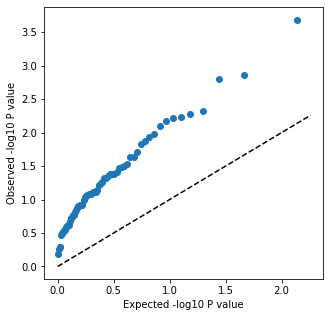

In [16]:
compiled=pd.DataFrame()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
p_values=df.sort_values(by="P-value")["P-value"].tolist()
plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values))
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.savefig("qq.pdf")

## Filter for variants with FDR < 10%

In [17]:
df=fdr(df,"P-value")

In [18]:
df_sig=df[df["fdr"]<0.1]

In [20]:
df_sig.head()

,index,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction,fdr,-log10(fdr)
0,224,2:219259844:A:G,g,g,319.0,3.709,0.000208,++++++,0.014373,1.842462
1,69,11:65561369:G:A,a,a,319.0,3.198,0.001384,++++++,0.036432,1.438517
2,181,1:89473624:G:A,a,a,319.0,3.159,0.001584,++++++,0.036432,1.438517
3,227,1:89478868:G:A,a,a,310.0,2.825,0.004733,++?+++,0.058417,1.233460
4,118,19:54848986:C:T,t,t,319.0,2.786,0.005336,++++++,0.058417,1.233460


In [21]:
compiled_icb=pd.DataFrame()

for x in files:
    df=pd.read_csv("/cellar/users/mpagadal/Data/immunotherapy-trials/associations/metal/"+x+".assoc.logistic.add",delimiter="\t")
    df["study"]=x
    compiled_icb=compiled_icb.append(df)

In [216]:
compiled_icb_plot=compiled_icb[~compiled_icb["study"].isin(["melanoma","rcc","nsclc"])]

In [217]:
compiled_icb_plot=compiled_icb_plot[compiled_icb_plot["ID"].isin(df_sig["MarkerName"].tolist())]

In [218]:
compiled_icb_plot=compiled_icb_plot.pivot(index="ID",columns="study",values="OR")

In [219]:
compiled_icb_plot.index=compiled_icb_plot.index.map(mp_assoc)

In [222]:
compiled_icb_plot.head()

study,hugo,miao,riaz,rizvi,snyder,vanallen
ID,,,,,,
11:65561369:G:A_CTSW,0.468466,2.024790e+00,0.096454,1.459060,1.840900,1.68532
12:69744014:C:A_LYZ,5.831680,3.627290e+01,7.862500,5.860070,3.928210,1.33080
19:54754385:T:G_LILRB2,0.359133,5.557970e-01,0.558366,0.355421,1.294300,3.60764
19:54848589:C:G_LAIR1,1.604090,7.127190e-08,1.276480,5.483400,0.873008,1.77212
19:54848986:C:T_LAIR1,2.631690,3.051300e+00,1.530640,0.082968,1.956450,1.26787


In [224]:
col=[]

for x in compiled_icb_plot.columns:
    if x in ["hugo","riaz","snyder","vanallen"]:
        col.append("green")
    if x in ["rizvi"]:
        col.append("red")
    else:
        col.append("blue")
        

In [230]:
compiled_icb_plot=compiled_icb_plot.fillna(0)

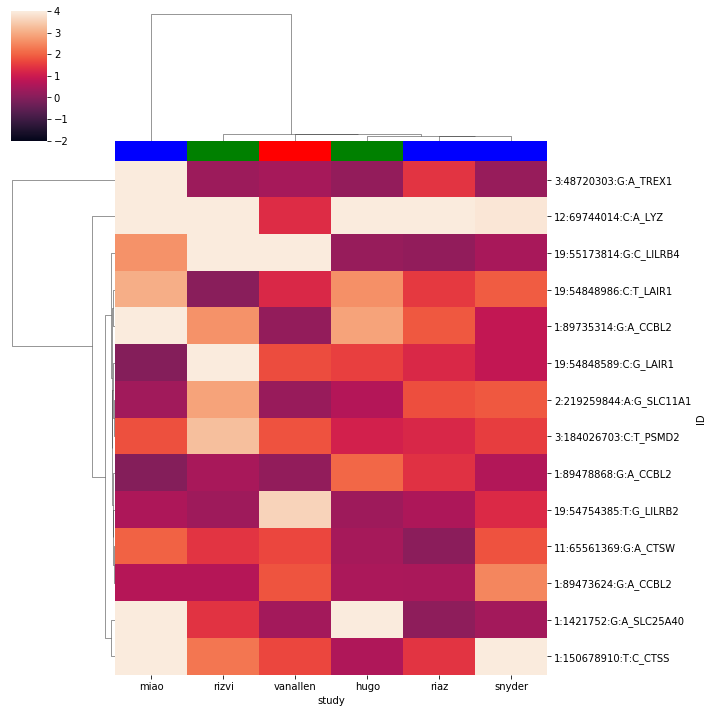

In [232]:
sns.clustermap(compiled_icb_plot,vmin=-2,vmax=4,col_colors=col)
plt.savefig("icb.clustermap.pdf")

In [ ]:
c

In [186]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-sig.tsv",delimiter="\t")

In [187]:
snps["assoc"]=snps["snps"]+"_"+snps["file"]

In [191]:
mp_assoc=dict(zip(snps["snps"],snps["assoc"]))

In [185]:
snps[snps["snps"].isin(compiled_icb_plot.index.tolist())]

,snps,file,category,maf,variant,rsid,chr,brian beta,brian SE,brian P,...,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,consensus p,p-value,cis tss
54,19:54848986:C:T,LAIR1,immunomodulators,0.2168,chr19:g.54848986C>T,rs36068997,19,-0.189505,0.020223,9.480300e-21,...,T,0.004545,0.020622,8.255600e-01,0.004824,0.020248,8.117140e-01,1,9.480300e-21,16248.0
61,19:54848589:C:G,LAIR1,immunomodulators,0.2526,chr19:g.54848589C>G,rs113109589,19,0.147105,0.019317,2.971350e-14,...,G,0.025998,0.019675,1.864260e-01,0.027989,0.019343,1.479620e-01,1,2.971350e-14,16645.0
77,19:54754385:T:G,LILRB2,antigen present,0.3326,chr19:g.54754385T>G,rs2361796,19,0.139727,0.017345,9.210950e-16,...,G,-0.018438,0.017799,3.002820e-01,-0.022086,0.017484,2.065590e-01,1,9.210950e-16,23289.0
88,1:150678910:T:C,CTSS,immunomodulators,0.3971,chr1:g.150678910T>C,rs1336899,1,0.126770,0.017082,1.296960e-13,...,C,0.132358,0.017305,2.309320e-14,0.138944,0.017029,3.957010e-16,3,3.957010e-16,23761.0
100,3:184026703:C:T,PSMD2,immunomodulators,0.4736,chr3:g.184026703C>T,rs6845,3,-0.107432,0.016608,1.055230e-10,...,T,-0.151142,0.016849,3.752580e-19,-0.150738,0.016523,9.352130e-20,3,9.352130e-20,-8335.0
171,2:219259844:A:G,SLC11A1,antigen present,0.3959,chr2:g.219259844A>G,rs1059823,2,0.104571,0.017444,2.137300e-09,...,G,0.097297,0.017682,3.878290e-08,0.098364,0.017343,1.469690e-08,3,2.137300e-09,-13093.0
199,19:55173814:G:C,LILRB4,immunomodulators,0.4903,chr19:g.55173814G>C,rs12609815,19,0.120665,0.016489,2.799120e-13,...,C,0.003134,0.016854,8.524960e-01,0.003552,0.016554,8.300930e-01,1,2.799120e-13,456.0
215,11:65561369:G:A,CTSW,cell type,0.2381,chr11:g.65561369G>A,rs12797706,11,0.113429,0.019533,6.633120e-09,...,A,0.112962,0.019896,1.420500e-08,0.113080,0.019509,7.064920e-09,3,6.633120e-09,85914.0
227,1:89473624:G:A,CCBL2,immunomodulators,0.2416,chr1:g.89473624G>A,rs61766155,1,-0.208965,0.019537,1.689610e-26,...,A,-0.229666,0.019801,8.054380e-31,-0.230115,0.019453,5.468840e-32,3,5.468840e-32,-72169.0
243,1:89478868:G:A,CCBL2,immunomodulators,0.1978,chr1:g.89478868G>A,rs113490655,1,0.129896,0.020950,5.948860e-10,...,A,0.122259,0.021290,9.723510e-09,0.126974,0.020805,1.095660e-09,3,5.948860e-10,-77413.0


In [116]:
snps[snps["snps"].isin(df[df["fdr"]<0.1]["MarkerName"].tolist())]

,snps,file,category,maf,variant,rsid,chr,brian beta,brian SE,brian P,...,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,consensus p,p-value,cis tss
54,19:54848986:C:T,LAIR1,immunomodulators,0.2168,chr19:g.54848986C>T,rs36068997,19,-0.189505,0.020223,9.480300e-21,...,T,0.004545,0.020622,8.255600e-01,0.004824,0.020248,8.117140e-01,1,9.480300e-21,16248.0
61,19:54848589:C:G,LAIR1,immunomodulators,0.2526,chr19:g.54848589C>G,rs113109589,19,0.147105,0.019317,2.971350e-14,...,G,0.025998,0.019675,1.864260e-01,0.027989,0.019343,1.479620e-01,1,2.971350e-14,16645.0
77,19:54754385:T:G,LILRB2,antigen present,0.3326,chr19:g.54754385T>G,rs2361796,19,0.139727,0.017345,9.210950e-16,...,G,-0.018438,0.017799,3.002820e-01,-0.022086,0.017484,2.065590e-01,1,9.210950e-16,23289.0
88,1:150678910:T:C,CTSS,immunomodulators,0.3971,chr1:g.150678910T>C,rs1336899,1,0.126770,0.017082,1.296960e-13,...,C,0.132358,0.017305,2.309320e-14,0.138944,0.017029,3.957010e-16,3,3.957010e-16,23761.0
100,3:184026703:C:T,PSMD2,immunomodulators,0.4736,chr3:g.184026703C>T,rs6845,3,-0.107432,0.016608,1.055230e-10,...,T,-0.151142,0.016849,3.752580e-19,-0.150738,0.016523,9.352130e-20,3,9.352130e-20,-8335.0
171,2:219259844:A:G,SLC11A1,antigen present,0.3959,chr2:g.219259844A>G,rs1059823,2,0.104571,0.017444,2.137300e-09,...,G,0.097297,0.017682,3.878290e-08,0.098364,0.017343,1.469690e-08,3,2.137300e-09,-13093.0
199,19:55173814:G:C,LILRB4,immunomodulators,0.4903,chr19:g.55173814G>C,rs12609815,19,0.120665,0.016489,2.799120e-13,...,C,0.003134,0.016854,8.524960e-01,0.003552,0.016554,8.300930e-01,1,2.799120e-13,456.0
215,11:65561369:G:A,CTSW,cell type,0.2381,chr11:g.65561369G>A,rs12797706,11,0.113429,0.019533,6.633120e-09,...,A,0.112962,0.019896,1.420500e-08,0.113080,0.019509,7.064920e-09,3,6.633120e-09,85914.0
227,1:89473624:G:A,CCBL2,immunomodulators,0.2416,chr1:g.89473624G>A,rs61766155,1,-0.208965,0.019537,1.689610e-26,...,A,-0.229666,0.019801,8.054380e-31,-0.230115,0.019453,5.468840e-32,3,5.468840e-32,-72169.0
243,1:89478868:G:A,CCBL2,immunomodulators,0.1978,chr1:g.89478868G>A,rs113490655,1,0.129896,0.020950,5.948860e-10,...,A,0.122259,0.021290,9.723510e-09,0.126974,0.020805,1.095660e-09,3,5.948860e-10,-77413.0


In [ ]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/immune-microenvironment/")